# Flowmeter (GAGE-1 & GAGE-2) data curation
This notebook describes setting up of flowmeter data for use with OLPROC.

## Background
GAGE-1 has been collecting streamflow measurements in creek Örbäcken for the complete duration of the studied period (2016-01-01 to 2020-01-01). However, based on results of a tracer test experiment initiated during 2016 (ref), the current consultant, Nirás AB, concluded that methods and equipment associated with GAGE-1 caused a considerable underappreciation of measured flow. 

Based on the above mentioned conclusion, a decision was made to install GAGE-2 in november 2018, in order to capture a more accurate response of system behaviour. The location of GAGE-1 and GAGE-2 is shown on the map below (figure 1).
![Hagfors map](../notebook_figures/hagfors-map-gages-loc.jpg "Hagfors map")
Figure 1. Map showing the Hagfors site and the location of the two gages. Creek Örbäcken highlighted in blue. Proposed modeling boundary highlighted in black.

The two measurement stations are located approximately 45 meters apart. Different methods are used to acquire data. GAGE-1 (figure 2) employs a method based in Torricelli's theorem in fluid dynamics, and collects data every four hours using a Diver pressure sensor. 

![GAGE-1](../notebook_figures/gage-1.jpg "GAGE-1")
Figure 2. Schematic and photo showing detail of GAGE-1 data acquisition. Modified from (ref).

GAGE-2 is an ISCO flow meter installed in a concrete tunnel beneath an overpass (figure 3), approximately 45 meters downstream of GAGE-1. GAGE-2 sampling time varies between every 2 to 30 minutes.

![GAGE-2](../notebook_figures/gage-2.jpg "GAGE-2")
Figure 3. Photo showing the concrete tunnel where GAGE-2 is installed. Modified from (ref).

## Aim and purpose
Although it was previously concluded that GAGE-1 underappreciate measured flow, the GAGE-1 dataset still contain information of value, because:
1. Relative information, such as increase or decrase in flow, is still captured in the data
2. The GAGE-1 dataset cover the complete duration of the studied period (the GAGE-2 dataset only partially cover the studied period)

In order to extract information from the GAGE-1 dataset, and to compensate for the underappreciation of measured flow, a model will be developed to estimate a "correction coefficient" (henceforth transformation coefficient, to avoid introducing confusing by using the word *correction*) for the GAGE-1 dataset. The model is developed under the assumption that the corresponding GAGE-2 dataset is the ground truth. This assumption is of course a simplification of reality, because:

1. The GAGE-2 dataset could itself be associated with imperfections
2. There is a distance of approximately 45 meters between the two measuring stations
3. Local stream morphology at the two locations are different
4. Other unknown unknowns

Hence, the purpose of this notebook is to:
  - Visualize and examine the raw data acquired by both gages
  - Determine a transformation coefficient for GAGE-1 based on a regression model
  - Transform the GAGE-1 dataset using the transformation coefficient
  - Curate the datasets into a format readable by OLPROC, for further use in a history-matching process

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pyemu
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
data_dir = os.path.join('..', '..', 'data', 'raw_data')
assert(data_dir)

In [3]:
os.listdir(data_dir)

['flowmeter_gage1.csv', 'flowmeter_gage2.csv']

**Note that all flow data has previously been converted into m<sup>3</sup>/day. These are the units used in subsequent MODFLOW simulations.**

GAGE-1 sample time is every four hours:

In [4]:
g1 = pd.read_csv(os.path.join(data_dir, 'flowmeter_gage1.csv'))
display(g1)

,datetime,flow
0,2016-01-01 00:00,6307.2
1,2016-01-01 04:00,5270.4
2,2016-01-01 08:00,5961.6
3,2016-01-01 12:00,6220.8
4,2016-01-01 16:00,7257.6
...,...,...
8766,2020-01-01 04:00,18057.6
8767,2020-01-01 08:00,17452.8
8768,2020-01-01 12:00,17452.8
8769,2020-01-01 16:00,17452.8


GAGE-2 sampling time is different in the beginning of the file (every second minute) compared to in the end of the file (every 30 minutes):

In [5]:
g2 = pd.read_csv(os.path.join(data_dir, 'flowmeter_gage2.csv'))
display(g2) # Gage 2 raw data is in cubic meters per second

,datetime,flow
0,2018-11-07 00:00,5529.6
1,2018-11-07 00:02,7516.8
2,2018-11-07 00:04,6825.6
3,2018-11-07 00:06,6566.4
4,2018-11-07 00:08,6739.2
...,...,...
22826,2020-01-01 21:30,29116.8
22827,2020-01-01 22:00,28771.2
22828,2020-01-01 22:30,28425.6
22829,2020-01-01 23:00,27993.6


Describe a few metrics of the two datasets:

In [6]:
g1.describe() #GAGE-1

,flow
count,8771.000000
mean,12603.495337
std,14090.084741
min,0.000000
25%,4320.000000
50%,8899.200000
75%,15206.400000
max,157420.800000


In [7]:
g2.describe() #GAGE-2

,flow
count,22831.000000
mean,18547.212614
std,15889.994849
min,0.000000
25%,6998.400000
50%,12096.000000
75%,27648.000000
max,102211.200000


We can observe minimum values of 0 in both datasets. Because depletion of creek Örbäcken have not been observed, zero-value measurements is very likely erroneous data. Since we don't want to fit a regression model to erroneous data, nor calibrate a flow model to zero-flow measurements, lets exclude zero-value data from the datasets.

Print the number of zero-values per dataset:

In [8]:
for i, df in enumerate([g1, g2]):
    print(f'Number of 0-value rows in g{i+1} dataframe: ' + str(df['flow'].isin([0]).sum()))

Number of 0-value rows in g1 dataframe: 63
Number of 0-value rows in g2 dataframe: 37


Exclude zero-value data:

In [9]:
# Exclude zero-value data
g1 = g1[(g1 != 0).all(1)]
g2 = g2[(g2 != 0).all(1)]

Describe anew:

In [10]:
g1.describe() # GAGE-1

,flow
count,8708.000000
mean,12694.678181
std,14099.975071
min,86.400000
25%,4406.400000
50%,8985.600000
75%,15292.800000
max,157420.800000


In [11]:
g2.describe() # GAGE-2

,flow
count,22794.000000
mean,18577.319084
std,15885.291492
min,86.400000
25%,6998.400000
50%,12096.000000
75%,27734.400000
max,102211.200000


New `min` is now 86.4 m<sup>3</sup>/day (1 liter per second).

Make sure `datetime` columns are of the actual data-type *datetime*:

In [12]:
for df in [g1, g2]:
    df['datetime'] = pd.to_datetime(df['datetime'])

Because the MODFLOW simulation time is `days`, flow observations used as input for OLPROC should at most be a single value per day. Let's create a function to resample the data and return a dataframe containing the daily average flow. In addition, let's also prepend the gage id to the data columns, to facilitate merging the dataframes in a subsequent step:

In [13]:
def resample_daily_avg(df, gage_name):
    df = df.resample('d', on='datetime').mean().dropna(how='all') # Compute daily average flow
    df = df.rename(columns={'flow': f'{gage_name}_flow'}) # Prepend gage id to data column
    return df

In [14]:
# Call the function which returns a resampled dataframe
g1_res = resample_daily_avg(g1, 'g1')
g2_res = resample_daily_avg(g2, 'g2')

Display five first rows of the resampled dataframes:

In [15]:
display(g1_res.head()) # GAGE-1

,g1_flow
datetime,
2016-01-01,6393.6
2016-01-02,6724.8
2016-01-03,4046.4
2016-01-04,4233.6
2016-01-05,5083.2


In [16]:
display(g2_res.head()) # GAGE-2

,g2_flow
datetime,
2018-11-07,7092.16
2018-11-08,8148.60
2018-11-09,7871.40
2018-11-10,8011.80
2018-11-11,9612.00


The original, raw data, is still assigned to `g1`and `g2`. `g1_res` and `g2_res` contain resampled daily average flow. 

Finally, before visualizing the datasets, let's also create subsets of the simultaneously measured data, i.e. the time period when GAGE-1 and GAGE-2 data is overlapping (2018-11-07 to 2020-01-01).

First, create a mask for the selected dates, so a subset of GAGE-1 raw data can be selected:

In [17]:
start_date, end_date = '2018-11-07', '2020-01-01'
mask = (g1['datetime'] >= start_date) & (g1['datetime'] <= end_date)

Secondly, merge dataframes into a complete subset containing daily averages from both gages:

In [18]:
s1 = pd.merge(g1_res, g2_res, how='inner', on=['datetime'])

The benefit of previously appending the gage id's are now clear:

In [19]:
display(s1)

,g1_flow,g2_flow
datetime,,
2018-11-07,10785.6,7092.16
2018-11-08,9763.2,8148.60
2018-11-09,9619.2,7871.40
2018-11-10,11448.0,8011.80
2018-11-11,12398.4,9612.00
...,...,...
2019-12-28,14947.2,26121.60
2019-12-29,15753.6,27442.80
2019-12-30,22752.0,35524.80


## Visualize the datasets

Let's examine the datasets in the following order:

  1. GAGE-1 and GAGE-2 original data
  2. GAGE-1 original data *and* daily average flow
  3. GAGE-2 original data *and* daily average flow

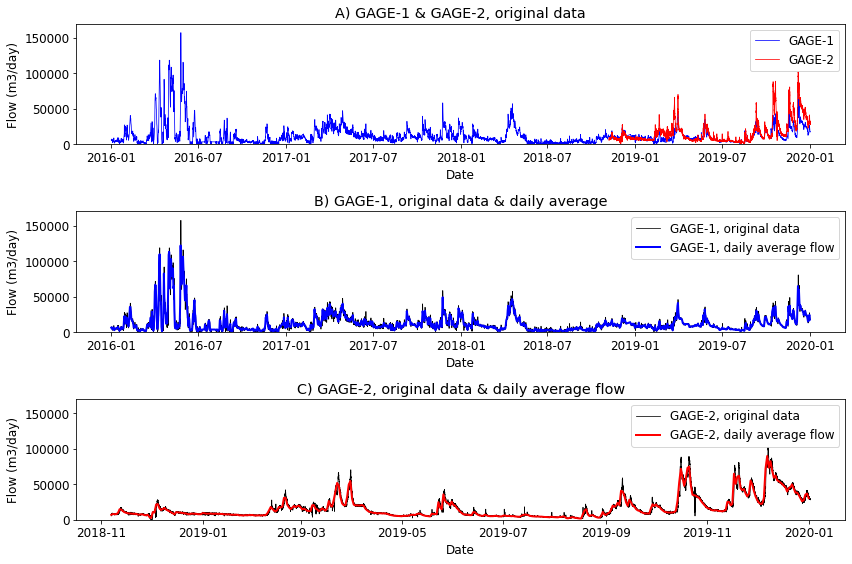

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(12,8))

# Plot GAGE-1 data
axs[0].plot(g1.datetime.values, g1.flow, lw=.75, c='blue', label='GAGE-1')
axs[0].plot(g2.datetime.values, g2.flow.values, lw=0.75, c='red', label='GAGE-2')
axs[0].title.set_text('A) GAGE-1 & GAGE-2, original data')

# Plot GAGE-1 data
axs[1].plot(g1.datetime.values, g1.flow, lw=.75, c='black', label='GAGE-1, original data')
axs[1].plot(g1_res.index, g1_res.g1_flow, lw=2, c='blue', label='GAGE-1, daily average flow')
axs[1].title.set_text('B) GAGE-1, original data & daily average')

# Plot GAGE-2 data
axs[2].plot(g2.datetime.values, g2.flow, lw=0.75, c='black', label='GAGE-2, original data')
axs[2].plot(g2_res.index, g2_res.g2_flow, lw=2., c='red', label='GAGE-2, daily average flow')
axs[2].title.set_text('C) GAGE-2, original data & daily average flow')

for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (m3/day)')
    ax.set_ylim([0,170000])
    ax.legend()

fig.tight_layout()
plt.show()

Looking at A), we can see when in time there is overlap in data. By examining the two datasets, it can also be observed that both gages capture the same general trend.

Looking at B) and C), it can be observed that computed daily average flow capture the trend of the measured (original) data. However, intra-day spikes (possibly due to precipitation falling directly on the stream, as well as nearby direct surface water runoff) are lost in the averaging process. 

Now, let's examine the time period with overlapping data specifically, to learn more about the differences between the two datasets. We do so by plotting the two subsets created earlier (one containing the original raw data and one containing daily average flow):

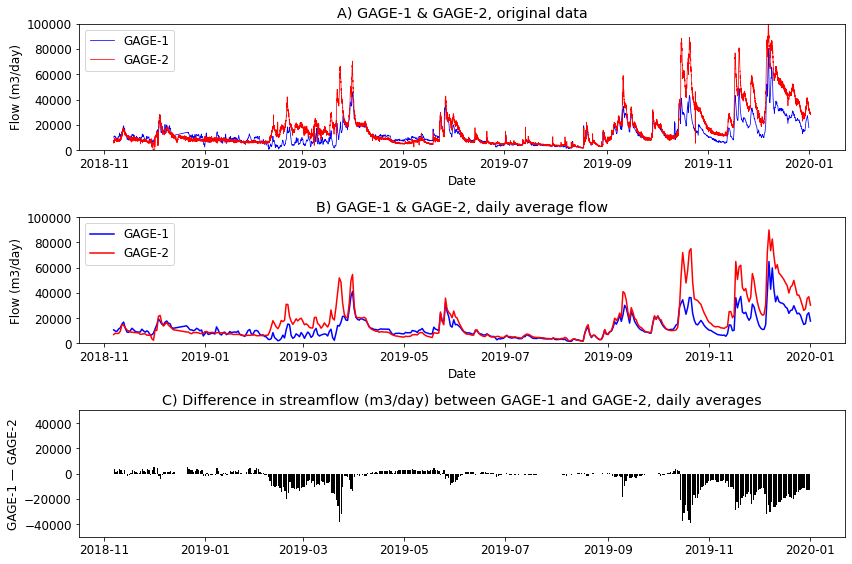

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(12,8))

# Plot GAGE-1 and GAGE-2 raw data
axs[0].plot(g1.loc[mask].datetime, g1.loc[mask].flow, c='blue', lw=0.75, label='GAGE-1')
axs[0].plot(g2.datetime.values, g2.flow, c='red', lw=0.75, label='GAGE-2')
axs[0].title.set_text('A) GAGE-1 & GAGE-2, original data')

# Plot GAGE-1 and GAGE-2 daily averages
axs[1].plot(s1.index, s1.g1_flow, c='blue', label='GAGE-1')
axs[1].plot(s1.index, s1.g2_flow, c='red', label='GAGE-2')
axs[1].title.set_text('B) GAGE-1 & GAGE-2, daily average flow')

# Plot differences between GAGE-1 and GAGE-2 daily averages
axs[2].bar(s1.index, (s1.g1_flow - s1.g2_flow), color='black', label='GAGE-1 — GAGE-2')
axs[2].set_ylim([-50000,50000])
axs[2].set_ylabel('GAGE-1 — GAGE-2')
axs[2].title.set_text('C) Difference in streamflow (m3/day) between GAGE-1 and GAGE-2, daily averages')

# Configure axis for the two upper subplots
for ax in axs[:2]:
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (m3/day)')
    ax.set_ylim([0,100000])
    ax.legend()

fig.tight_layout()
plt.show()

By examining the plots above, it can be observed that both gages capture the same trend. This is important information, because it tells us that GAGE-1 is indeed able to capture system behaviour. At least partially so.

Some difference in flow should be expected between the two gages. After all, they are situated approximately 45 meters apart, with differing stream bottom morphology. However, during periods of variable flow, *in particular during high flow*, GAGE-1 fail to capture the magnitude of streamflow. Because of this, let's try to create a *transformation coefficient* and an uncertainty bound for GAGE-1, so that GAGE-1 data, during the period before GAGE-2 was installed, can be used rather than omitted.

To do so, lets create a linear regression model where we treat GAGE-2 measurements as the ground truth. To avoid introducing bias originating from a specific flow regime, lets first shuffle the data:

In [22]:
s1_shuffle = s1.sample(frac=1)

## Linear regression model
Perform the linear regression:

In [23]:
x, y = np.array(s1_shuffle['g1_flow']), np.array(s1_shuffle['g2_flow'])
X = x.reshape(-1, 1)

# Split the data into training/testing sets
X_train = X[:-80]
X_test = X[-80:]

# Split the targets into training/testing sets
y_train = y[:-80]
y_test = y[-80:]

# # Create linear regression object
lr = LinearRegression()

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lr.predict(X_test)

# Root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

# r^2 (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Regression line slope
slope = lr.coef_[0]

Visualize the results of linear regression:

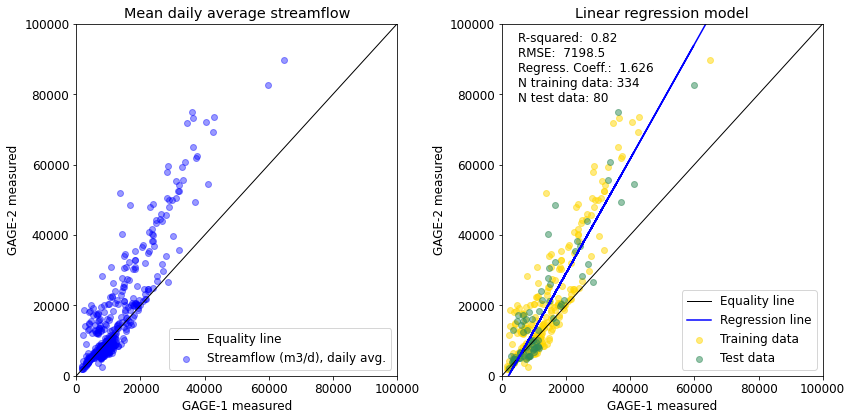

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axslim = [0, 100000]

# Regression line across entire plot (just a cosmetic effect)
X_test_extrpol = np.array(axslim).reshape(-1, 1)
y_pred_extrpol = lr.predict(X_test_extrpol)

# Plot GAGE-1 vs GAGE-2 (daily averages)
axs[0].set_xlim(axslim), axs[0].set_ylim(axslim)
axs[0].plot(axslim, axslim, c='black', linewidth=1, label='Equality line')
axs[0].scatter(x, y, c='blue', alpha=0.4, label='Streamflow (m3/d), daily avg.')
axs[0].set_xlabel('GAGE-1 measured')
axs[0].set_ylabel('GAGE-2 measured')
axs[0].title.set_text('Mean daily average streamflow')

# Plot Regression model
axs[1].scatter(X_train, y_train, alpha=0.5,  color='gold', label='Training data')
axs[1].scatter(X_test, y_test, alpha=0.5, color='seagreen', label='Test data')
axs[1].plot(axslim, axslim, c='black', linewidth=1, label='Equality line')
axs[1].plot(X_test, y_pred, color='blue', label='Regression line')
axs[1].plot(X_test_extrpol, y_pred_extrpol, color='blue') # Elongate regression line
axs[1].title.set_text('Linear regression model')
axs[1].text(5000, 78000, f'R-squared: {r2: .2f}\nRMSE: {rmse: .1f}\nRegress. Coeff.: {slope: .3f}\nN training data: {len(X_train)}\nN test data: {len(X_test)}')

for axis in axs:
    axis.set_xlabel('GAGE-1 measured')
    axis.set_ylabel('GAGE-2 measured')
    axis.set_xlim(axslim), axis.set_ylim(axslim)
    axis.legend(loc='lower right')

fig.tight_layout()
plt.show()

Let's transform the GAGE-1 dataset by applying the transformation coefficient. Let's also formulate an upper and lower uncertainty bound for the transformed dataset. RMSE is the standard deviation of the residuals. The uncertainty bound can roughly be estimated to 2σ (95% interval).

Apply the transformation coefficient on the GAGE-1 data(sub)set:

In [25]:
s1['g1_transf'] = s1['g1_flow'] * slope

Define lower and upper uncertainty bound:

In [26]:
s1['g1_transf_lb'] = s1['g1_transf'] - (2 * rmse)
s1['g1_transf_ub'] = s1['g1_transf'] + (2 * rmse)

Describe the transformed data(sub)set:

In [27]:
s1.describe()

,g1_flow,g2_flow,g1_transf,g1_transf_lb,g1_transf_ub
count,414.000000,414.000000,414.000000,414.000000,414.000000
mean,12418.543768,16921.208566,20190.880160,5793.829914,34587.930406
std,8891.631803,15669.882546,14456.596161,14456.596161,14456.596161
min,1627.200000,1850.400000,2645.608117,-11751.442129,17042.658363
25%,6786.000000,6661.800000,11033.122347,-3363.927899,25430.172593
50%,9950.400000,10504.800000,16178.010699,1780.960453,30575.060945
75%,15361.200000,20476.350000,24975.243000,10578.192754,39372.293246
max,64785.600000,89793.000000,105332.663001,90935.612755,119729.713247


It can be observed that the lower bound (column `g1_transf_lb`) has a minimum value of `-11063.038302`. Let's enforce some subjective opinon on this lower bound by assuming that streamflow in the creek will probably not disobey the laws of physics and start flowing uphill.

Hence, apply a minimum lower bound of 86.4 m<sup>3</sup>/day (1 liter per second, minimum measured value):

In [28]:
s1['g1_transf_lb'] = [86.4 if i < 86.4 else i for i in s1['g1_transf_lb']]

Describe again:

In [29]:
s1.describe()

,g1_flow,g2_flow,g1_transf,g1_transf_lb,g1_transf_ub
count,414.000000,414.000000,414.000000,414.000000,414.000000
mean,12418.543768,16921.208566,20190.880160,7905.564456,34587.930406
std,8891.631803,15669.882546,14456.596161,12859.537885,14456.596161
min,1627.200000,1850.400000,2645.608117,86.400000,17042.658363
25%,6786.000000,6661.800000,11033.122347,86.400000,25430.172593
50%,9950.400000,10504.800000,16178.010699,1780.960453,30575.060945
75%,15361.200000,20476.350000,24975.243000,10578.192754,39372.293246
max,64785.600000,89793.000000,105332.663001,90935.612755,119729.713247


Visualize the transformation of the simultaneously measured subset (daily average flow) by plotting:  

A)
  - GAGE-1 dataset
  - GAGE-1 with applied transformation coefficient
  - Uncertainty bounds of the transformed dataset
  - GAGE-2 dataset (*assumed* ground truth)

B)
  - Difference between the transformed GAGE-1 and GAGE-2 datasets

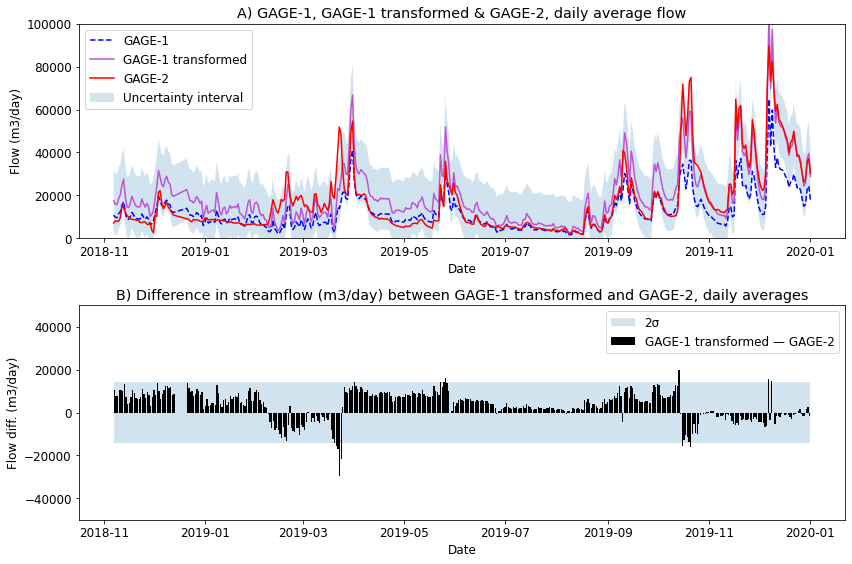

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))

# Plot GAGE-1, GAGE-1 transformed (using transformation coefficient) and GAGE-2 daily averages
axs[0].set_ylim([0,100000])
axs[0].plot(s1.index, s1.g1_flow, ls='--', c='blue', label='GAGE-1')
axs[0].plot(s1.index, s1.g1_transf, c='mediumorchid', label='GAGE-1 transformed')
axs[0].fill_between(s1.index, s1.g1_transf_lb, s1.g1_transf_ub, alpha=0.2, label='Uncertainty interval')
axs[0].plot(s1.index, s1.g2_flow, c='red', label='GAGE-2')
axs[0].set_ylabel('Flow (m3/day)')
axs[0].title.set_text('A) GAGE-1, GAGE-1 transformed & GAGE-2, daily average flow')

# Plot differences between GAGE-1 transformed and GAGE-2 daily averages
axs[1].bar(s1.index, (s1.g1_transf - s1.g2_flow), color='black', label='GAGE-1 transformed — GAGE-2')
axs[1].set_ylim([-50000,50000])
axs[1].set_ylabel('Flow diff. (m3/day)')
axs[1].title.set_text('B) Difference in streamflow (m3/day) between GAGE-1 transformed and GAGE-2, daily averages')
axs[1].fill_between(s1.index, (2 * rmse), -1 * (2 * rmse), alpha=0.2, label='2σ')

# Configure axis for the two upper subplots
for ax in axs[:2]:
    ax.set_xlabel('Date')
    ax.legend()

fig.tight_layout()
plt.show()

By examining the figures above, it can be observed that `GAGE-1 transformed` now instead overestimates streamflow for certain periods of time. However, it can also be observed that for periods of high streamflow, GAGE-1 transformed is a better approximation for GAGE-2 (assumed ground truth), than GAGE-1. The uncertainty interval cover GAGE-2 data, except for periods of extreme variability.

Finally, let's apply the transformation coefficient on the resampled *daily average streamflow* dataset (`g1_res`), which contain data for the entire studied period:

In [31]:
g1_res['transf'] = g1_res['g1_flow'] * slope # Apply transformation coefficient
g1_res['transf_lb'] = g1_res['transf'] - (2 * rmse) # Initial lower uncertainty bound
g1_res['transf_ub'] = g1_res['transf'] + (2 * rmse)# Upper uncertainty bound
g1_res['transf_lb'] = [86.4 if i < 86.4 else i for i in g1_res['transf_lb']] # Assume laws of physics apply

Visualize the transformed dataset:

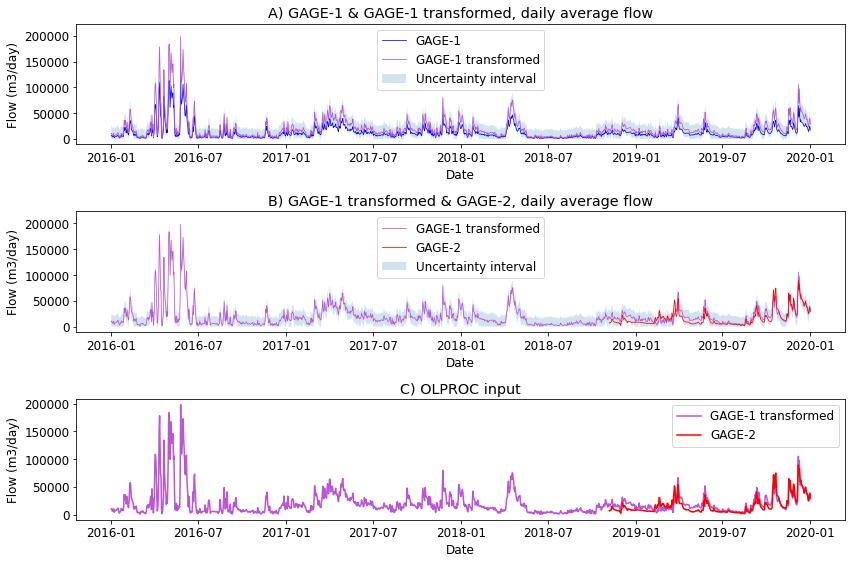

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(12,8))

# Plot GAGE-1, GAGE-1 transformed and uncertainty interval
axs[0].plot(g1_res.index, g1_res.g1_flow, lw=.75, c='blue', label='GAGE-1')
axs[0].plot(g1_res.index, g1_res.transf, lw=.75, c='mediumorchid', label='GAGE-1 transformed')
axs[0].fill_between(g1_res.index, g1_res.transf_lb, g1_res.transf_ub, alpha=0.2, label='Uncertainty interval')
axs[0].title.set_text('A) GAGE-1 & GAGE-1 transformed, daily average flow')

# Plot GAGE-1 transformed, GAGE-2 and uncertainty interval
axs[1].plot(g1_res.index, g1_res.transf, lw=.75, c='mediumorchid', label='GAGE-1 transformed')
axs[1].plot(g2_res.index, g2_res.g2_flow, lw=.75, c='red', label='GAGE-2')
axs[1].fill_between(g1_res.index, g1_res.transf_lb, g1_res.transf_ub, alpha=0.2, label='Uncertainty interval')
axs[1].title.set_text('B) GAGE-1 transformed & GAGE-2, daily average flow')

# Plot OLPROC input
axs[2].plot(g1_res.index, g1_res.transf, c='mediumorchid', label='GAGE-1 transformed')
axs[2].plot(g2_res.index, g2_res.g2_flow, c='red', label='GAGE-2')
axs[2].title.set_text('C) OLPROC input')

for ax in axs:
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (m3/day)')
    ax.legend()

fig.tight_layout()
plt.show()

## Prepare datasets for OLPROC

OLPROC reads site sample files (ssf/smp), which is long format data. The following section describes:
1. Transforming `GAGE-1 transformed` from wide to long format data
2. Transforming `GAGE-2` from wide to long format data
3. Merging the two datasets
4. Exporting the merged dataset to a site sample file using `pyemu.utils.smp_utils.dataframe_to_smp`

Function for transforming data:

In [33]:
def wide_to_long(df, gage_no, value_col):
    df['name'] = f'GAGE-{gage_no}'
    df['datetime'] = df.index
    return pd.melt(df, id_vars=['name', 'datetime'], value_vars=[value_col])

Create long-form versions of the two datasets:

In [34]:
g1_res_lf = wide_to_long(g1_res, 1, 'transf')
g2_res_lf = wide_to_long(g2_res, 2, 'g2_flow')

Merge the two datasets:

In [35]:
olproc_input = pd.concat([g1_res_lf, g2_res_lf])

Perhaps a redundant step, but for brevities sake let's change the clock hour for each `datetime` entry from `00:00:00` to `12:00:00`, to better reflect that data represent daily average streamflow:

In [36]:
olproc_input['datetime'] = [i.replace(hour=12) for i in olproc_input['datetime']]

Visualize the concatenated dataframe:

In [37]:
display(olproc_input)

,name,datetime,variable,value
0,GAGE-1,2016-01-01 12:00:00,transf,10395.132779
1,GAGE-1,2016-01-02 12:00:00,transf,10933.619387
2,GAGE-1,2016-01-03 12:00:00,transf,6578.901601
3,GAGE-1,2016-01-04 12:00:00,transf,6883.263597
4,GAGE-1,2016-01-05 12:00:00,transf,8264.598808
...,...,...,...,...
416,GAGE-2,2019-12-28 12:00:00,g2_flow,26121.600000
417,GAGE-2,2019-12-29 12:00:00,g2_flow,27442.800000
418,GAGE-2,2019-12-30 12:00:00,g2_flow,35524.800000
419,GAGE-2,2019-12-31 12:00:00,g2_flow,36986.400000


Use `pyemu.utils.smp_utils.dataframe_to_smp` to create a site sample file:

In [38]:
output_dir = os.path.join('..', '..', 'data', 'observations')

In [39]:
pyemu.utils.smp_utils.dataframe_to_smp(
    olproc_input,
    os.path.join(output_dir, 'measured_streamflow.ssf'),
    name_col='name',
    datetime_col='datetime',
    value_col='value',
    datetime_format='dd/mm/yyyy',
    value_format='{0:15.6E}',
    max_name_len=12
)

## References
1. TODO